Using device: cpu


100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1, Loss: 1900.5906
Epoch 2, Loss: 211.4410
Epoch 3, Loss: 70.6230
Epoch 4, Loss: 26.4358
Epoch 5, Loss: 10.4956
Epoch 6, Loss: 4.6053
Epoch 7, Loss: 3.1085
Epoch 8, Loss: 3.3217
Epoch 9, Loss: 4.0955
Epoch 10, Loss: 3.3839
Model saved as vae_cifar10.pth


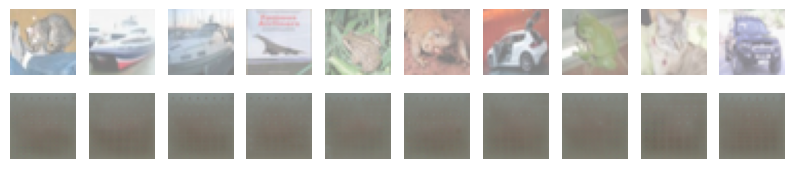

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Ensure proper visualization in Colab
%matplotlib inline

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data Augmentation and Preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define the Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, 64 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder_fc(z).view(-1, 64, 8, 8)
        x = self.decoder(x)
        return x, mu, logvar

# Loss Function (Reconstruction + Beta-VAE KL Loss)
def loss_function(recon_x, x, mu, logvar, beta=4):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div

# Initialize Model, Optimizer, and Train
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)  # L2 Regularization

def train(epoch):
    vae.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Train the VAE Model
for epoch in range(10):
    train(epoch)

# Save the trained model
torch.save(vae.state_dict(), "/content/vae_cifar10.pth")
print("Model saved as vae_cifar10.pth")

# Visualization of Reconstructed Images
def visualize_reconstructions():
    vae.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = vae(data)

        # Normalize to [0,1] range
        data = (data * 0.5) + 0.5
        recon = (recon * 0.5) + 0.5

        # Convert images to grid format
        fig, axes = plt.subplots(2, 10, figsize=(10, 2))
        for i in range(10):
            axes[0, i].imshow(data[i].cpu().permute(1, 2, 0).numpy())
            axes[1, i].imshow(recon[i].cpu().permute(1, 2, 0).numpy())
            axes[0, i].axis('off')
            axes[1, i].axis('off')
        plt.show()

# Call the visualization function
visualize_reconstructions()